In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import examples as eg
import numpy as np
from numpy import *
import dionysus

The circular coordinates pipeline for examining different smoothness cost-functions:

    Step 1. Getting the point cloud
    Step 2. Computing the Vietoris-Rips filtration and its cohomology
    Step 3. Selecting the Cocycle
    Step 4. First smoothing using Least Squares (Optional)
    Step 5. Second smoothing using a new cost function

## Step 1 - Getting the point cloud

In [3]:
annulus = eg.pinched_torus_example(n=200)
#The examples.py generates data points in form of point clouds that can be analyzed using the imported dionysus module.

## Step 2 - Computing Vietoris-Rips Complexes and Cohomology

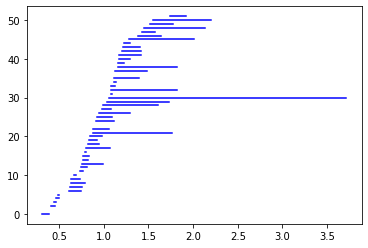

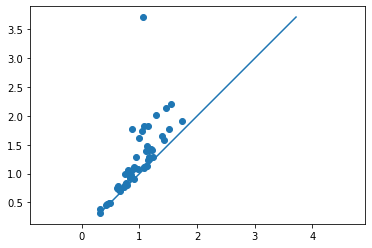

In [4]:
prime = 23 #choose the prime base for the coefficient field that we use to construct the persistence cohomology.

vr = dionysus.fill_rips(annulus, 2, 4.) #Vietoris-Rips complex
cp = dionysus.cohomology_persistence(vr, prime, True) #Create the persistent cohomology based on the chosen parameters.
dgms = dionysus.init_diagrams(cp, vr) #Calculate the persistent diagram using the designated coefficient field and complex.
dionysus.plot.plot_bars(dgms[1], show=True) 
dionysus.plot.plot_diagram(dgms[1], show=True) 
#dionysus.plot.plot_diagram(dgms[0], show=True) 
#Plot the barcode and diagrams using matplotlib incarnation within Dionysus2. This mechanism is different in Dionysus.

## Step 3 - Selecting the cocycle and visualization.

In [5]:
type(plt)

module

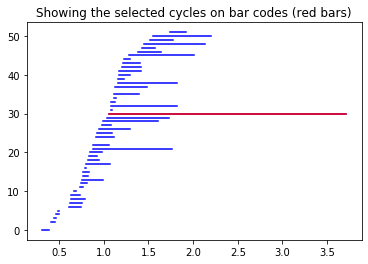

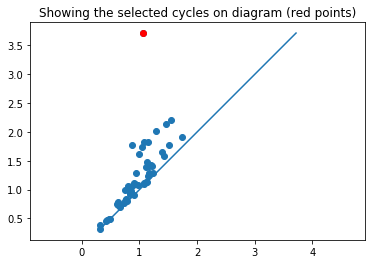

In [5]:
threshold = 1
bars = [bar for bar in dgms[1] if bar.death-bar.birth > threshold] #choosing cocycle that persist at least threshold=1.
cocycles = [cp.cocycle(bar.data) for bar in bars]
#plt is the matplotlib incarnation.

#Red highlight cocyles that persist more than threshold value on barcode, when more than one cocyles have persisted over threshold values, this plots the first one.
dionysus.plot.plot_bars(dgms[1], show=False)
plt.plot([[bar.birth,bar.death] for bar in dgms[1] if bar.death-bar.birth > threshold][0],[[x,x] for x,bar in enumerate(dgms[1]) if bar.death-bar.birth > threshold][0],'r')
plt.title('Showing the selected cycles on bar codes (red bars)')
plt.show()

#Red highlight ***ALL*** cocyles that persist more than threshold value on diagram.
dionysus.plot.plot_diagram(dgms[1], show=False)
Lt1 = [[point.birth,point.death] for point in dgms[1] if point.death-point.birth > threshold] 
for Lt3 in Lt1:
    #print(Lt3)
    plt.plot(Lt3[0],Lt3[1],'ro')
plt.title('Showing the selected cycles on diagram (red points)')
plt.show()


In [7]:
chosen_cocycle= cocycles[0]
chosen_bar= bars[0]

## Step 4 - First smoothing using Least Squares (Optional)

If it is computed the smoothed coefficients can be used as initial condition for the optimization code

In [8]:
vr_8 = dionysus.Filtration([s for s in vr if s.data <= max([bar.birth for bar in bars])])
coords = dionysus.smooth(vr_8, chosen_cocycle, prime)

### Visualization

In [9]:
np.shape(annulus.T)
annulus.T[1,:]

array([-2.00508897,  1.20362447,  2.40415289,  3.04326264,  2.1568479 ,
        3.93622072,  1.27962633,  1.90079576,  3.92236424,  1.21402323,
        0.09961478, -1.43949787,  0.11915736, -0.90601696, -0.23756278,
       -2.16994545, -2.05953864, -2.0209653 , -1.98722423,  1.83351228,
       -0.23450408, -0.72958746, -1.07602218,  3.06613617,  3.52966921,
       -2.05974359, -2.25915   ,  1.19311805, -1.49262047,  1.85765028,
       -0.37499451, -0.81360144, -1.46045023,  2.15032601,  0.9576045 ,
        0.83230723, -1.0499545 , -2.26680817,  2.11450556,  0.30349523,
       -2.80436707,  3.65778482,  1.59307866, -3.72148371,  3.21935934,
       -3.14894429,  1.95540164, -0.51859973, -1.73901113,  1.52006897,
        3.92977568, -1.22762048,  0.89503248,  0.58962693,  2.84903371,
        1.11616751, -1.02539547,  0.05390425,  0.74388582,  1.66779298,
        0.64971302, -1.32349791,  0.51069434,  3.29352978, -2.40809596,
        3.79772269,  2.16727999,  3.28163315, -2.11894721, -4.03

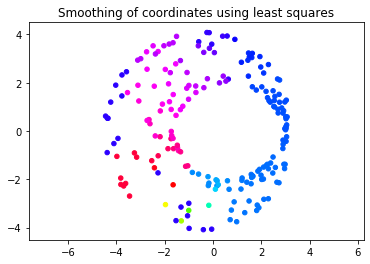

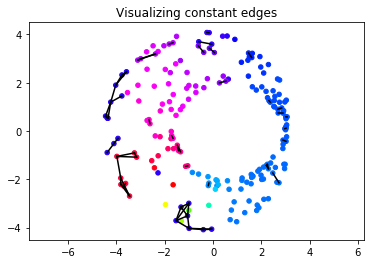

In [10]:
#plt.rcParams['lines.markersize'] = 150
scatter(annulus.T[0,:],annulus.T[1,:],s=20, c=coords, cmap="hsv")
plt.axis('equal')
plt.title('Smoothing of coordinates using least squares')
plt.show()

toll = 1e-5
p,val = (chosen_bar,coords)
edges_costant = []
thr = p.birth # i want to check all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    if abs(val[s[0]]-val[s[1]]) <= toll:
        edges_costant.append([annulus[s[0],:],annulus[s[1],:]])
edges_costant = np.array(edges_costant)
scatter(annulus.T[0,:],annulus.T[1,:],s=20, c=coords, cmap="hsv")
plot(edges_costant.T[0,:],edges_costant.T[1,:], c='k')
plt.axis('equal')
plt.title('Visualizing constant edges')
plt.show()

## Step 5 - Second smoothing using a new cost function

In [11]:
import utils
l2_cocycle,f,bdry = utils.optimizer_inputs(vr, bars, chosen_cocycle, coords, prime)

In [62]:
#l2_cocycle.reshape(-1, 1)
l2_cocycle = l2_cocycle.reshape(-1, 1)
l2_cocycle.shape
f-bdry*l2_cocycle

array([[ 1.34261787e-04],
       [ 0.00000000e+00],
       [ 7.21521040e-04],
       ...,
       [-7.25702799e-01],
       [ 2.54886444e-02],
       [-3.46376230e-02]])

In [13]:
##It does not seem to work to have double invokes here...
import scipy as scp
from scipy.optimize import minimize
#cost = lambda z: cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)
#grad = lambda z: cost_functions.grad_Lpnorm_mvj(z, F= f, B= bdry, p= 20)
def cost(z):
    import cost_functions
    return cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)

def grad(z):
    import cost_functions
    return cost_functions.grad_Lpnorm_mvj(z, F= f, B= bdry, p= 20)

#res = minimize(cost, l2_cocycle, method='L-BFGS-B', jac = grad)
res=scp.optimize.minimize(cost, l2_cocycle, method="Nelder-Mead") 
res

 final_simplex: (array([[-0.05451331,  0.28114358, -0.12064127, ...,  0.05098397,
        -0.35296924,  0.04656912],
       [-0.05696441,  0.28471171, -0.12123665, ...,  0.05021478,
        -0.35123827,  0.04911355],
       [-0.05586976,  0.28959666, -0.1201513 , ...,  0.04395024,
        -0.3496279 ,  0.0462421 ],
       ...,
       [-0.05578217,  0.3030439 , -0.12044484, ...,  0.06175777,
        -0.36074508,  0.04456829],
       [-0.05392428,  0.29577467, -0.12064941, ...,  0.07376492,
        -0.35477235,  0.04658347],
       [-0.05531316,  0.29315442, -0.1205647 , ...,  0.06823311,
        -0.35421269,  0.04844229]]), array([1.25956829, 1.25973874, 1.25979526, 1.25984778, 1.26002425,
       1.26016862, 1.26033665, 1.26035373, 1.26037607, 1.26040775,
       1.26047032, 1.26049098, 1.2605934 , 1.26059794, 1.26069819,
       1.26075562, 1.26076727, 1.26077282, 1.26093538, 1.26096887,
       1.2609698 , 1.26099686, 1.26100837, 1.2610201 , 1.26103036,
       1.26104095, 1.26106399, 1.2

In [102]:
import tensorflow as tf
#import tensorflow_probability as tfp
'''Following seems deprecated in newer version of tfp
#pip install --upgrade tensorflow-probability==0.70
#alternatively, we can use tensorflow to minimize the cost function without gradient information, here we can use multiple black-box functions like Adams
#For more: Check at https://www.tensorflow.org/probability/api_docs/python/tfp/math/minimize
x = tf.Variable(0.)
cost_fun = lambda: cost_functions.cost_Lpnorm_mvj(x, F= f, B= bdry, p= 20)
res_tfp=tfp.math.minimize(
        cost_fun,
        num_steps=1000,
        optimizer=tfp.optimizers.Adam(learning_rate=0.1)
        )
'''
#Following seems working, c.f. 
#https://stackoverflow.com/questions/55552715/tensorflow-2-0-minimize-a-simple-function
def cost(z):
    import cost_functions
    return cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)
#type(bdry)
#scipy.sparse.csr.csr_matrix
B_mat = bdry.todense()
import tensorflow as tf
print(f.shape)
print((B_mat*l2_cocycle).shape)
z = tf.Variable(l2_cocycle, trainable=True)

#L1 in tensorflow language
cost_z = tf.reduce_sum( tf.abs(f - B_mat @ z) )
#L2 in tensorflow language
cost_z = tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),2 ) )
#Lp+alpha*Lq norm in tensorflow language
lp=1
lq=4
alpha=0.8
cost_z = tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lp ) ), 1/lp) + alpha* tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lq ) ), 1/lq)

#Gradient Descedent Optimizer
opt_gd = tf.train.GradientDescentOptimizer(0.1).minimize(cost_z)
#Adams Optimizer
opt_adams = tf.train.AdamOptimizer(1e-4).minimize(cost_z)
#The latter is much better in terms of result

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):#How many iterations you want to run?
        #print(sess.run([x,loss]))
        sess.run(opt_adams)
    res_tf=sess.run([z,cost_z])
type(res_tf)
print(res_tf)
res_tf=res_tf[0]
res_tf

(8058, 1)
(8058, 1)
[array([[-0.07115968],
       [-0.07114568],
       [-0.07113611],
       [-0.07112636],
       [-0.07114245],
       [ 0.06375783],
       [-0.07115078],
       [ 0.06379926],
       [ 0.06378252],
       [ 0.06379566],
       [-0.0711468 ],
       [ 0.24585197],
       [-0.07114524],
       [ 0.1502833 ],
       [-0.07114713],
       [ 0.15029387],
       [-0.07116794],
       [-0.07116559],
       [-0.07116094],
       [-0.07112804],
       [ 0.09663156],
       [ 0.15028713],
       [-0.07115521],
       [-0.07113091],
       [ 0.06379791],
       [-0.07116104],
       [-0.07116707],
       [-0.07115104],
       [-0.07115912],
       [ 0.06379298],
       [-0.0711546 ],
       [ 0.15029966],
       [ 0.24360921],
       [ 0.06374056],
       [-0.07113759],
       [ 0.06379808],
       [ 0.15028529],
       [-0.07117085],
       [-0.07114127],
       [ 0.06503996],
       [-0.07115722],
       [ 0.06380095],
       [ 0.06380059],
       [-0.30423522],
       [-0.

array([[-0.07115968],
       [-0.07114568],
       [-0.07113611],
       [-0.07112636],
       [-0.07114245],
       [ 0.06375783],
       [-0.07115078],
       [ 0.06379926],
       [ 0.06378252],
       [ 0.06379566],
       [-0.0711468 ],
       [ 0.24585197],
       [-0.07114524],
       [ 0.1502833 ],
       [-0.07114713],
       [ 0.15029387],
       [-0.07116794],
       [-0.07116559],
       [-0.07116094],
       [-0.07112804],
       [ 0.09663156],
       [ 0.15028713],
       [-0.07115521],
       [-0.07113091],
       [ 0.06379791],
       [-0.07116104],
       [-0.07116707],
       [-0.07115104],
       [-0.07115912],
       [ 0.06379298],
       [-0.0711546 ],
       [ 0.15029966],
       [ 0.24360921],
       [ 0.06374056],
       [-0.07113759],
       [ 0.06379808],
       [ 0.15028529],
       [-0.07117085],
       [-0.07114127],
       [ 0.06503996],
       [-0.07115722],
       [ 0.06380095],
       [ 0.06380059],
       [-0.30423522],
       [-0.07113001],
       [-0

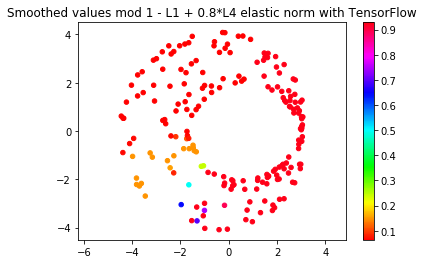

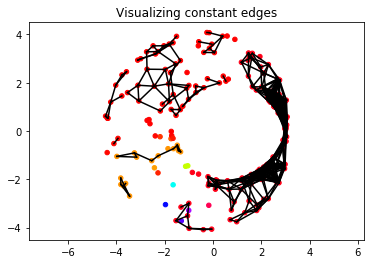

In [103]:
color = np.mod(res_tf.T[0,:],1)
scatter(annulus.T[0,:],annulus.T[1,:],s=20, c=color, cmap="hsv")
#scatter(*annulus.T, c= color, cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('Smoothed values mod 1 - L{} + {}*L{} elastic norm with TensorFlow'.format(lp,alpha,lq))
plt.show()
toll = 1e-5
edges_constant = []
thr = chosen_bar.birth # i want to check constant edges in all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    if abs(color[s[0]]-color[s[1]]) <= toll:
        edges_constant.append([annulus[s[0],:],annulus[s[1],:]])
edges_constant = np.array(edges_constant)        
#scatter(*annulus.T, c=color, cmap="hsv", alpha=.5)
scatter(annulus.T[0,:],annulus.T[1,:],s=20, c=color, cmap="hsv")
#plot(*edges_constant.T, c='k')
plot(edges_constant.T[0,:],edges_constant.T[1,:], c='k')
edges_constant.shape
plt.axis('equal')
plt.title('Visualizing constant edges')
plt.show()